Training of model which has prediction noise in the image ability. 

In [1]:
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout,Conv2D,Conv2DTranspose,Activation,Flatten,LeakyReLU # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.models import Model# type: ignore
from IPython.display import clear_output
import tensorflow.keras.backend as K# type: ignore
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import tqdm
import time
import cv2
import gc
import os

In [2]:
global IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL,BATCH_SIZE,EPOCHS,IMAGES_PATH
IMAGE_WIDTH = 1200
IMAGE_HEIGHT = 600
IMAGE_CHANNEL = 3
BATCH_SIZE = 4
SEGMENT_PER_IMAGE = 4
EPOCHS = 100
AUTO_SAVE_PERIOT = 1
TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")

DATA_LIMIT = 100
IMAGES_PATH = './images_1'
TEST_IMAGES_PATH = './images_2'
BATCH_COUNT = int(DATA_LIMIT / BATCH_SIZE)

In [3]:
tf.config.list_physical_devices()
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

# DATA

### PREPROCESS

In [4]:
def add_loud(image,noise_mean=20,noise_std=50,say=False):
    """
    Adds noise to image
    input:
        image
    return:
        noisy_image: noise added original image
        noise: noise map which added
    """
    noise = np.clip(np.random.normal(20,50,image.shape).astype(np.float32),-255,255)
    noisy = image + noise
    
    high_mask = np.clip(noisy,255,510) - 255
    lower_mask = np.clip(noisy,-255,0)
    mixed_mask = high_mask + lower_mask
    new_noise = noise - mixed_mask
    
    
    new_noisy = image + new_noise
    if say:
        def _say(im):
            print()
            print(im.dtype)
            print("MAX:",im.max())
            print("MIN:",im.min())
    
        for i in [noise,noisy,lower_mask,high_mask,mixed_mask,new_noise,new_noisy]:
            _say(i)
    return np.uint8(new_noisy),np.uint8(new_noise)
    

    
def scale_im(im):
    im = im / 255
    return im

def descale_im(im):
    im = im * 255
    im = im.astype(np.uint8)

    min_val = im.min()
    max_val = im.max()

    if min_val < 0 or max_val > 255:    
        # 0 ile 255 arasında ölçekleme yap
        im = ((im - min_val) / (max_val - min_val) * 255).astype('uint8')
        
    return im

### DATA LOADING

In [5]:
## total data file size
total = 0
TOTAL_DATA_COUNT = 0
for i in os.listdir(IMAGES_PATH)[:DATA_LIMIT]:
    path = f"{IMAGES_PATH}/{i}"
    size = os.path.getsize(path)
    total += size
    TOTAL_DATA_COUNT +=1

print(f"DATASET SIZE: {total / (1024 * 1024):.2f} MB")  # Megabyte
print(f"TOTAL DATA COUNT: {TOTAL_DATA_COUNT}")

DATASET SIZE: 29.83 MB
TOTAL DATA COUNT: 100


In [6]:
def segment_im(im, sub_im_width=1200, sub_im_height=600):
    shape = tf.shape(im)  
    im_height, im_width = shape[0], shape[1]

    top_left = im[0:sub_im_height, 0:sub_im_width]    
    top_right = im[0:sub_im_height, im_width-sub_im_width:im_width]    
    bottom_left = im[im_height-sub_im_height:im_height, 0:sub_im_width]    
    bottom_right = im[im_height-sub_im_height:im_height, im_width-sub_im_width:im_width]   

    return [top_left, top_right, bottom_left, bottom_right]


def load_dataset():        
    names = os.listdir(IMAGES_PATH)[:DATA_LIMIT]
    image_paths = list(f"{IMAGES_PATH}/{name}" for name in names)
 
    images = []
    for image_path in tqdm.tqdm(image_paths):
        image = cv2.imread(image_path)
        segments = segment_im(image)
        
        for segment in segments:
            images.append(segment)

    return np.array(images),np.array(images[0])

def get_slice(data,start_idx,end_idx):
    images = data[start_idx:end_idx]
    noisies,noises,clears = [],[],[]
    for i,orig in enumerate(images):
        noisy,noise = add_loud(orig)
        noisies.append(scale_im(noisy))
        noises.append(scale_im(noise))
        images[i] = scale_im(orig)
    images = np.array(images)
    noisies = np.array(noisies)
    noises = np.array(noises)
    
    clears = np.ones_like(images) * 0.01
    
    return images,clears,noisies,noises


## MODEL

In [7]:
def create_model():
    inp = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL))

    x = Conv2D(24,(5,5),(2,2),padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(24,(3,3),(2,2),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(24,(3,3),(2,2),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)

    out = Conv2DTranspose(3,(5,5),(2,2),padding='same',activation='sigmoid')(x)

    return Model(inp,out,name='noisier_model')

opt = Adam(learning_rate=0.0002,beta_1=0.5)
model = create_model()
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "noisier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 1200, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 300, 600, 24)      1824      
                                                                 
 batch_normalization (BatchN  (None, 300, 600, 24)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 600, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 300, 24)      5208      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 300, 24)     96        
 hNormalization)                                     

## TRAINING

In [8]:
def save_checkpoint(epoch,model,clear_loss,clear_acc,noisy_loss,noisy_acc,interval_test_sample):

    model.save(f'./training/noise-predictor/{TRAIN_TOPIC}_{epoch}.h5')
    
    # metrics save
    f = open('./training/noise-predictor-checkpoint.txt','a')
    f.writelines(f"\ntrain:{TRAIN_TOPIC} epoch:{epoch} clear_loss:{clear_loss:.7f} noisy_loss:{noisy_loss:.7f} clear_acc:{clear_acc:.7f} noisy_acc:{noisy_acc}")
    f.close()

    # sample save
    cv2.imwrite(f'./training/samples/{TRAIN_TOPIC}_{epoch}.jpg',interval_test_sample)

def interval_test(model,orig_im):
    noisy_im,noise = add_loud(orig_im)
    
    noisy_im = scale_im(noisy_im)
    orig_im = scale_im(np.uint8(orig_im))

    noisy_im = np.expand_dims(noisy_im,axis=0)
    orig_im = np.expand_dims(orig_im,axis=0)
    
    orig_est =model.predict(orig_im)
    noisy_est = model.predict(noisy_im)

    orig_im = descale_im(np.reshape(orig_im,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    orig_est = descale_im(np.reshape(orig_est,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    noisy_im = descale_im(np.reshape(noisy_im,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))
    noisy_est = descale_im(np.reshape(noisy_est,newshape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL)))

    sample = np.zeros((IMAGE_HEIGHT*3,IMAGE_WIDTH*2,3), dtype=np.uint8)
    sample[0:IMAGE_HEIGHT,0:IMAGE_WIDTH] = orig_im
    sample[0:IMAGE_HEIGHT,IMAGE_WIDTH:IMAGE_WIDTH*2] = noisy_im
    sample[IMAGE_HEIGHT:IMAGE_HEIGHT*2,0:IMAGE_WIDTH] =orig_est.astype(np.uint8)
    sample[IMAGE_HEIGHT:IMAGE_HEIGHT*2,IMAGE_WIDTH:IMAGE_WIDTH*2] = noisy_est.astype(np.uint8)
    sample[IMAGE_HEIGHT*2:IMAGE_HEIGHT*3,0:IMAGE_WIDTH] =cv2.subtract(orig_im,orig_est).astype(np.uint8)
    sample[IMAGE_HEIGHT*2:IMAGE_HEIGHT*3,IMAGE_WIDTH:IMAGE_WIDTH*2] = cv2.subtract(noisy_im,noisy_est).astype(np.uint8)

    return sample

def show_outputs(clear_losses,clear_accs,noisy_losses,noisy_acces,interval_test_sample):
    epochs_history = range(len(clear_losses))

    plt.figure(figsize=(10,7))    
    plt.imshow(cv2.cvtColor(interval_test_sample,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Test')
    plt.show()

    # Loss grafiği
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_history, clear_losses, label='Clear losses', color='blue', marker='o')
    plt.plot(epochs_history, noisy_losses, label='Noisy losses', color='green', marker='s')

    # Grafik ayarları
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Acc grafiği
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_history, clear_accs, label='Clear Accuracies', color='blue', marker='o')
    plt.plot(epochs_history, noisy_acces, label='Noisy Accuracies', color='green', marker='s')

    # Grafik ayarları
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    



In [9]:
global clear_losses,clear_accs,noisy_losses,noisy_accs
def train(model,dataset,test_im):
    tf.keras.backend.clear_session()

    clear_losses,clear_accs,noisy_losses,noisy_accs = [],[],[],[]
    for i in tqdm.tqdm(range(EPOCHS)):
        ep_start_time = time.time()
        ep_clear_loss,ep_clear_acc,ep_noisy_loss,ep_noisy_acc = 0,0,0,0
        
        counter = 0
        for j in tqdm.tqdm(range(BATCH_COUNT)):

            orig_batch,clear_batch,noisy_batch,noise_batch = get_slice(dataset,i*BATCH_SIZE,(i+1)*BATCH_SIZE)

            #training
            clear_loss,clear_acc = model.train_on_batch(noisy_batch,noise_batch)
            noisy_loss,noisy_acc = model.train_on_batch(orig_batch,clear_batch)

            #metrics
            ep_clear_loss += clear_loss
            ep_clear_acc += clear_acc
            ep_noisy_loss += noisy_loss
            ep_noisy_acc += noisy_acc
            counter += 1

        ep_clear_acc / counter
        ep_clear_loss / counter
        ep_noisy_acc / counter
        ep_noisy_loss / counter
        clear_losses.append(ep_clear_loss)
        clear_accs.append(ep_clear_acc)
        noisy_losses.append(ep_noisy_loss)
        noisy_accs.append(ep_noisy_acc)
        
        # Bellek temizliği
        gc.collect()
        K.clear_session()
        
        clear_output()
        interval_test_sample = interval_test(model,test_im)
        show_outputs(clear_losses,clear_accs,noisy_losses,noisy_accs,interval_test_sample) 

        print("EPOCH:",i)
        print("MODEL_CLEAR,LOSS - ACC:",ep_clear_acc," ",ep_clear_loss)
        print("MODEL_NOISY,LOSS - ACC:",ep_noisy_acc," ",ep_noisy_loss)
        print("USED VRAM MEMORY: ",tf.config.experimental.get_memory_info('GPU:0'))  # VRAM bilgisi
        print("ELAPSED TIME: ",time.time()-ep_start_time)
        # save
        if i % AUTO_SAVE_PERIOT == 0:
            save_checkpoint(counter,model,ep_clear_loss,ep_clear_acc,ep_noisy_loss,ep_noisy_acc,interval_test_sample)
            

### TRAIN

In [10]:
dataset,test_data= load_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.44it/s]


1/1 [==============================] - 0s 22ms/step


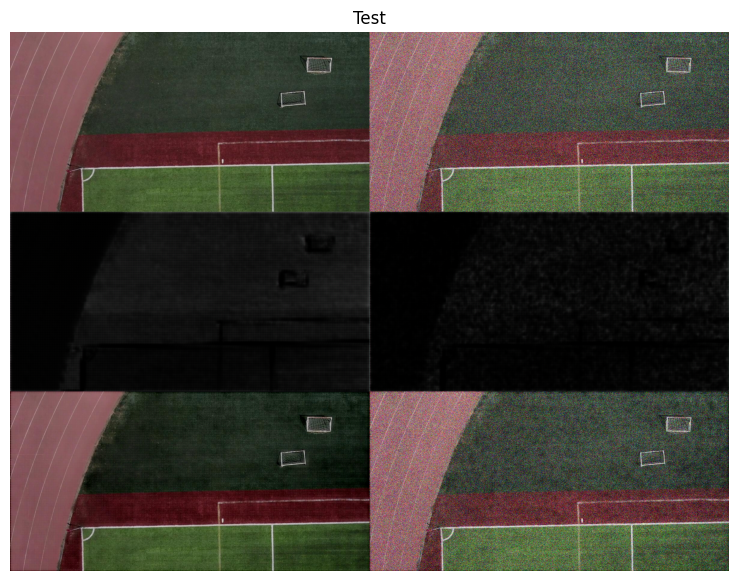

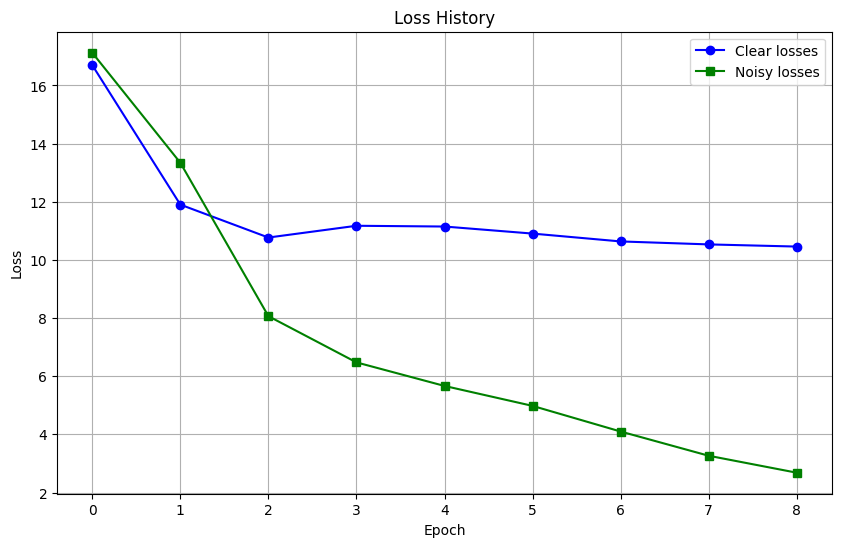

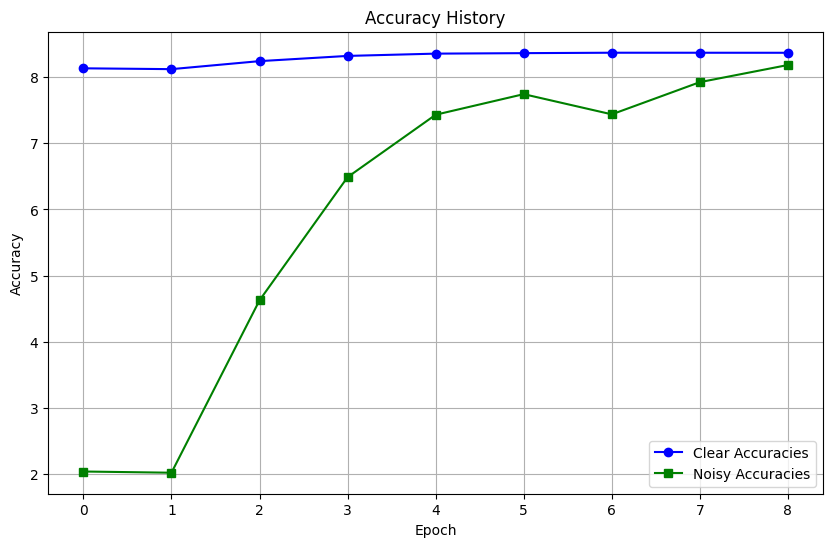

  9%|███████▍                                                                          | 9/100 [03:39<37:00, 24.40s/it]

EPOCH: 8
MODEL_CLEAR,LOSS - ACC: 8.369608998298645   10.458692461252213
MODEL_NOISY,LOSS - ACC: 8.184617131948471   2.6805954053997993
USED VRAM MEMORY:  {'current': 319488, 'peak': 1109824000}
ELAPSED TIME:  23.600601196289062



  4%|███▎                                                                               | 1/25 [00:01<00:33,  1.38s/it]

In [ ]:
train(model,dataset,test_data)

In [ ]:
dataset!!